# 1. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 4.6 MB/s eta 0:00:00


In [ ]:
# Typicals
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
import chardet
import pickle
import math
from scipy.stats import ttest_1samp
from itertools import product
import math

# Options
pd.set_option('display.max_columns', 100)

# SKlearn
    # Pipeline
from sklearn.pipeline import Pipeline

    # Preprocessing
from sklearn.preprocessing import StandardScaler
from category_encoders.one_hot import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split

    # Models
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

    # Metrics
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import f1_score,roc_auc_score,roc_curve

# 2. Final model

## 2.1 Classification model with validation set


### 2.1.1 Model

In [ ]:
y_dict_test = {}
y_dict_val = {}

for year in range(2000,2022):

    print(f'######  Model for year {year}, in process...  #######')

    # Define the file path
    file_X_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_train_',str(year),'.csv'])
    file_X_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_test_',str(year),'.csv'])
    file_y_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_train_',str(year),'.csv'])
    file_y_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_test_',str(year),'.csv'])

    # Read the CSV file into a NumPy array
    X_train = np.genfromtxt(file_X_train, delimiter=',')
    X_future = np.genfromtxt(file_X_test, delimiter=',')
    y_train = np.genfromtxt(file_y_train, delimiter=',')
    y_future = np.genfromtxt(file_y_test, delimiter=',')

    ################
    # Validation set:
    ################

    X_val, X_test, y_val, y_test = train_test_split(X_future, y_future, test_size=0.50, random_state=10)

    # Set the target variable:
    y_classification_train = np.zeros(len(y_train))
    y_classification_train[y_train > 0] = 1

    y_classification_test = np.zeros(len(y_test))
    y_classification_test[y_test > 0] = 1

    y_classification_val = np.zeros(len(y_val))
    y_classification_val[y_val > 0] = 1

    print(f'Training instances: {X_train.shape[0]}')
    print(f'Validation instances: {X_val.shape[0]}')
    print(f'Test instances: {X_test.shape[0]}')

    ################
    # Fit the model:
    ################

    # Extra trees classifier
    et = ExtraTreesClassifier(n_estimators=50, min_samples_split=0.01, random_state=42)
    model_et = et.fit(X_train, y_classification_train)

    ###############
    # Predictions:
    ###############

    # Calculate the probabilities
    y_prob_test = model_et.predict_proba(X_test)
    y_prob_val = model_et.predict_proba(X_val)

    ###############
    # Metrics:
    ###############

    print(f'######  Model for year {year}, done  #######')

    ##############
    # Store the results:
    ##############
    y_store_test = pd.DataFrame(columns=['y_test','y_prob_test'])
    y_store_val = pd.DataFrame(columns=['y_val','y_prob_val'])

    y_store_test['y_test'] = y_test
    y_store_test['y_prob_test'] = y_prob_test[:,1]

    y_store_val['y_val'] = y_val
    y_store_val['y_prob_val'] = y_prob_val[:,1]

    y_dict_test[year] = y_store_test
    y_dict_val[year] = y_store_val

######  Model for year 2000, in process...  #######
Training instances: 2308
Validation instances: 140
Test instances: 141
######  Model for year 2000, done  #######
######  Model for year 2001, in process...  #######
Training instances: 2589
Validation instances: 146
Test instances: 146
######  Model for year 2001, done  #######
######  Model for year 2002, in process...  #######
Training instances: 2881
Validation instances: 149
Test instances: 149
######  Model for year 2002, done  #######
######  Model for year 2003, in process...  #######
Training instances: 3179
Validation instances: 150
Test instances: 151
######  Model for year 2003, done  #######
######  Model for year 2004, in process...  #######
Training instances: 3480
Validation instances: 155
Test instances: 155
######  Model for year 2004, done  #######
######  Model for year 2005, in process...  #######
Training instances: 3790
Validation instances: 159
Test instances: 160
######  Model for year 2005, done  #######
####

In [ ]:
for year in range(2000,2022):

    # Dataframe
    df_test = y_dict_test[year]
    df_val = y_dict_val[year]
    # File name
    file_results_test = ''.join(['/content/drive/MyDrive/TFM/06. Results/final/results_test_',str(year),'.csv'])
    file_results_val = ''.join(['/content/drive/MyDrive/TFM/06. Results/final/results_val_',str(year),'.csv'])

    df_test.to_csv(file_results_test, sep=',')
    df_val.to_csv(file_results_val, sep=',')

### 2.1.2. Tuning how many companies to select

In [ ]:
returns = pd.DataFrame(columns=['selection','mean_test','median_test','mean_whole_test','mean_val','median_val','mean_whole_val'])

for selection in range(1,180):

    mean_test_arr = np.array([])
    median_test_arr = np.array([])
    mean_whole_test_arr = np.array([])
    mean_val_arr = np.array([])
    median_val_arr = np.array([])
    mean_whole_val_arr = np.array([])

    for year in range(2000,2022):

        # File name
        file_name_test = ''.join(['/content/drive/MyDrive/TFM/06. Results/final/results_test_',str(year),'.csv'])
        file_name_val = ''.join(['/content/drive/MyDrive/TFM/06. Results/final/results_val_',str(year),'.csv'])

        df_test = pd.read_csv(file_name_test)
        df_val = pd.read_csv(file_name_val)

        sorted_test = df_test.loc[:,['y_test','y_prob_test']].sort_values('y_prob_test', ascending=False)
        sorted_val = df_val.loc[:,['y_val','y_prob_val']].sort_values('y_prob_val', ascending=False)

        # Calculate relevant variables
        # Test values
        mean_test = sorted_test['y_test'][:selection].mean()
        median_test = sorted_test['y_test'][:selection].median()
        mean_whole_test = sorted_test['y_test'].mean()
        # Validation values
        mean_val = sorted_val['y_val'][:selection].mean()
        median_val = sorted_val['y_val'][:selection].median()
        mean_whole_val = sorted_val['y_val'].mean()

        # Append all the variables
        mean_test_arr = np.append(mean_test_arr,mean_test)
        median_test_arr = np.append(median_test_arr,median_test)
        mean_whole_test_arr = np.append(mean_whole_test_arr,mean_whole_test)
        mean_val_arr = np.append(mean_val_arr,mean_val)
        median_val_arr = np.append(median_val_arr,median_val)
        mean_whole_val_arr = np.append(mean_whole_val_arr,mean_whole_val)

    new_row = pd.DataFrame({
                            'selection': [selection],
                            'mean_test': [np.mean(mean_test_arr)],
                            'median_test': [np.mean(median_test_arr)],
                            'mean_whole_test': [np.mean(mean_whole_test_arr)],
                            'mean_val': [np.mean(mean_val_arr)],
                            'median_val': [np.mean(median_val_arr)],
                            'mean_whole_val': [np.mean(mean_whole_val_arr)]
                            })

    returns = pd.concat([returns, new_row],ignore_index=True)

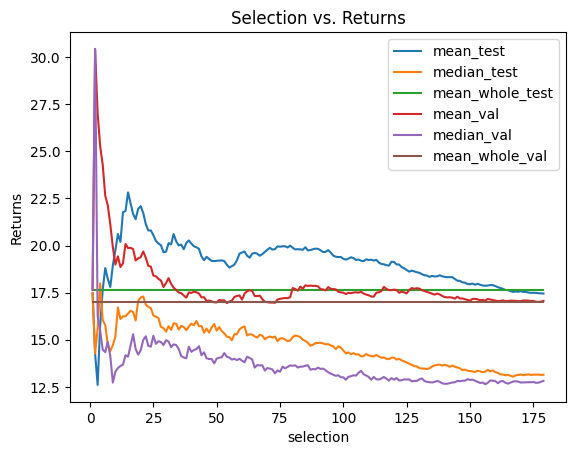

In [ ]:
# Get the column names
columns = returns.columns

# Create the plot
plt.figure()

# Plot each column against the first column
for col in columns[1:]:
    plt.plot(returns[columns[0]], returns[col], label=col)

# Add labels and title to the plot
plt.xlabel(columns[0])
plt.ylabel("Returns")
plt.title("Selection vs. Returns")

# Add a legend
plt.legend()

# Show the plot
plt.show()

Taking in consideration the mean and median values of the validation set, the maximum return is obtained when selecting 15 companies.

## 3. Grid search for tuning

The hyperparameters to tune will be:

* How many companies to select
* Number of estimators
* Minimum sample splits

In [ ]:
returns = pd.DataFrame(columns=['selection','trees','min_samples','mean_test','mean_whole_test','mean_val','mean_whole_val'])

selection_lst = [10,15,20,25]
trees_lst = [50,100,200,500,1000,2000]
min_samples_lst = [0.001,0.005,0.01,0.05]

for selection, trees, min_samples in product(selection_lst,trees_lst,min_samples_lst):

    mean_test_arr = np.array([])
    mean_whole_test_arr = np.array([])
    mean_val_arr = np.array([])
    mean_whole_val_arr = np.array([])

    for year in range(2000,2022):

        # Define the file path
        file_X_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_train_',str(year),'.csv'])
        file_X_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_test_',str(year),'.csv'])
        file_y_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_train_',str(year),'.csv'])
        file_y_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_test_',str(year),'.csv'])

        # Read the CSV file into a NumPy array
        X_train = np.genfromtxt(file_X_train, delimiter=',')
        X_future = np.genfromtxt(file_X_test, delimiter=',')
        y_train = np.genfromtxt(file_y_train, delimiter=',')
        y_future = np.genfromtxt(file_y_test, delimiter=',')

        ################
        # Validation set:
        ################

        X_test, X_val, y_test, y_val = train_test_split(X_future, y_future, test_size=0.50, random_state=10)

        # Set the target variable:
        y_classification_train = np.zeros(len(y_train))
        y_classification_train[y_train > 0] = 1

        y_classification_test = np.zeros(len(y_test))
        y_classification_test[y_test > 0] = 1

        y_classification_val = np.zeros(len(y_val))
        y_classification_val[y_val > 0] = 1

        ################
        # Fit the model:
        ################

        # Extra trees classifier
        et = ExtraTreesClassifier(n_estimators=trees, min_samples_split=min_samples, random_state=42)
        model_et = et.fit(X_train, y_classification_train)

        ###############
        # Predictions:
        ###############

        # Calculate the probabilities
        y_prob_test = model_et.predict_proba(X_test)
        y_prob_val = model_et.predict_proba(X_val)

        ##############
        # Store the results:
        ##############
        y_store_test = pd.DataFrame(columns=['y_test','y_prob_test'])
        y_store_val = pd.DataFrame(columns=['y_val','y_prob_val'])

        y_store_test['y_test'] = y_test
        y_store_test['y_prob_test'] = y_prob_test[:,1]

        y_store_val['y_val'] = y_val
        y_store_val['y_prob_val'] = y_prob_val[:,1]

        # Now sort the predictions

        sorted_test = y_store_test.loc[:,['y_test','y_prob_test']].sort_values('y_prob_test', ascending=False)
        sorted_val = y_store_val.loc[:,['y_val','y_prob_val']].sort_values('y_prob_val', ascending=False)

        # Calculate relevant variables
        # Test values
        mean_test = sorted_test['y_test'][:selection].mean()
        mean_whole_test = sorted_test['y_test'].mean()
        # Validation values
        mean_val = sorted_val['y_val'][:selection].mean()
        mean_whole_val = sorted_val['y_val'].mean()

        # Append all the variables
        mean_test_arr = np.append(mean_test_arr,mean_test)
        mean_whole_test_arr = np.append(mean_whole_test_arr,mean_whole_test)
        mean_val_arr = np.append(mean_val_arr,mean_val)
        mean_whole_val_arr = np.append(mean_whole_val_arr,mean_whole_val)

    new_row = pd.DataFrame({
                            'selection': [selection],
                            'trees': [trees],
                            'min_samples': [min_samples],
                            'mean_test': [np.mean(mean_test_arr)],
                            'mean_whole_test': [np.mean(mean_whole_test_arr)],
                            'mean_val': [np.mean(mean_val_arr)],
                            'mean_whole_val': [np.mean(mean_whole_val_arr)]
                            })
    print(new_row)
    returns = pd.concat([returns, new_row],ignore_index=True)

In [ ]:
csv_to_save = '/content/drive/MyDrive/TFM/06. Results/final/returns.csv'

# Save the DataFrame to a CSV file
returns.to_csv(csv_to_save)


Los hyperparametros optimizados entonces son:

* trees = 2000
* minimum samples split = 0.001
* selection = 10

In [32]:
returns2 = pd.read_csv('/content/drive/MyDrive/TFM/06. Results/final/returns.csv', sep=';')

In [35]:
returns2 = returns2[returns2.selection>5]
returns2.sort_values(by='mean_val', ascending=False).head(3)

,Unnamed: 0,selection,trees,min_samples,mean_test,mean_whole_test,mean_val,mean_whole_val
40,40,10,1000,0.001,23.448488,17.029797,24.308186,17.650897
76,76,20,100,0.001,19.748298,17.029797,22.889843,17.650897
64,64,15,1000,0.001,21.991196,17.029797,22.825099,17.650897


In [25]:
returns = pd.DataFrame(columns=['selection','trees','min_samples','mean_test','mean_whole_test','mean_val','mean_whole_val'])

selection = 10

mean_test_arr = np.array([])
mean_whole_test_arr = np.array([])
mean_val_arr = np.array([])
mean_whole_val_arr = np.array([])

for year in range(2000,2022):

    print(f'#### year {year} in progress...###')
    # Define the file path
    file_X_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_train_',str(year),'.csv'])
    file_X_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_test_',str(year),'.csv'])
    file_y_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_train_',str(year),'.csv'])
    file_y_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_test_',str(year),'.csv'])

    # Read the CSV file into a NumPy array
    X_train = np.genfromtxt(file_X_train, delimiter=',')
    X_future = np.genfromtxt(file_X_test, delimiter=',')
    y_train = np.genfromtxt(file_y_train, delimiter=',')
    y_future = np.genfromtxt(file_y_test, delimiter=',')

    ################
    # Validation set:
    ################

    X_val, X_test, y_val, y_test = train_test_split(X_future, y_future, test_size=0.50, random_state=10)

    # Set the target variable:
    y_classification_train = np.zeros(len(y_train))
    y_classification_train[y_train > 0] = 1

    y_classification_test = np.zeros(len(y_test))
    y_classification_test[y_test > 0] = 1

    y_classification_val = np.zeros(len(y_val))
    y_classification_val[y_val > 0] = 1

    ################
    # Fit the model:
    ################

    # Extra trees classifier
    et = ExtraTreesClassifier(n_estimators=1000, min_samples_split=0.001, random_state=42)
    model_et = et.fit(X_train, y_classification_train)

    ###############
    # Predictions:
    ###############

    # Calculate the probabilities
    y_prob_test = model_et.predict_proba(X_test)
    y_prob_val = model_et.predict_proba(X_val)

    ##############
    # Store the results:
    ##############
    y_store_test = pd.DataFrame(columns=['y_test','y_prob_test'])
    y_store_val = pd.DataFrame(columns=['y_val','y_prob_val'])

    y_store_test['y_test'] = y_test
    y_store_test['y_prob_test'] = y_prob_test[:,1]

    y_store_val['y_val'] = y_val
    y_store_val['y_prob_val'] = y_prob_val[:,1]

    # Now sort the predictions

    sorted_test = y_store_test.loc[:,['y_test','y_prob_test']].sort_values('y_prob_test', ascending=False)
    sorted_val = y_store_val.loc[:,['y_val','y_prob_val']].sort_values('y_prob_val', ascending=False)

    # Calculate relevant variables
    # Test values
    mean_test = sorted_test['y_test'][:selection].mean()
    mean_whole_test = sorted_test['y_test'].mean()
    # Validation values
    mean_val = sorted_val['y_val'][:selection].mean()
    mean_whole_val = sorted_val['y_val'].mean()

    # Append all the variables
    mean_test_arr = np.append(mean_test_arr,mean_test)
    mean_whole_test_arr = np.append(mean_whole_test_arr,mean_whole_test)
    mean_val_arr = np.append(mean_val_arr,mean_val)
    mean_whole_val_arr = np.append(mean_whole_val_arr,mean_whole_val)

#### year 2000 in progress...###
#### year 2001 in progress...###
#### year 2002 in progress...###
#### year 2003 in progress...###
#### year 2004 in progress...###
#### year 2005 in progress...###
#### year 2006 in progress...###
#### year 2007 in progress...###
#### year 2008 in progress...###
#### year 2009 in progress...###
#### year 2010 in progress...###
#### year 2011 in progress...###
#### year 2012 in progress...###
#### year 2013 in progress...###
#### year 2014 in progress...###
#### year 2015 in progress...###
#### year 2016 in progress...###
#### year 2017 in progress...###
#### year 2018 in progress...###
#### year 2019 in progress...###
#### year 2020 in progress...###
#### year 2021 in progress...###


In [26]:
# Create a pandas Series with random values
diff_hp = mean_test_arr - mean_whole_test_arr

# Perform one-sample t-test
t_statistic, p_value = ttest_1samp(diff_hp, 0, alternative='greater')

# Print the results
print("One-Sample t-test Results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

One-Sample t-test Results:
t-statistic: 1.7659798691045172
p-value: 0.04596749675729447


In [22]:
diff_hp

array([  2.8519455 ,  40.2649902 , -27.96574986,  30.70112617,
         6.77263759,  31.36942395,   8.65407487,  23.89079675,
        17.91881765,  20.82557623,  17.87433345,  -1.41747163,
        -6.24783512,  -1.72133946,  17.59195631, -14.54657582,
       -11.22157301,  14.21625009,  33.59647238,  62.25304844,
        17.19079028, -23.44353748])

# 4. Training the final model

Now, extract the final model and obtian some insights about what companies have the model select in the past and what companies to select for the future.

## 4.1. HP tuning for the final model

In [ ]:
returns = pd.DataFrame(columns=['selection','trees','min_samples','mean_test','mean_whole_test'])

selection_lst = [10,15,20,25]
trees_lst = [50,100,200,500,1000,2000]
min_samples_lst = [0.001,0.005,0.01,0.05]

for selection, trees, min_samples in product(selection_lst,trees_lst,min_samples_lst):

    mean_test_arr = np.array([])
    mean_whole_test_arr = np.array([])
    mean_val_arr = np.array([])
    mean_whole_val_arr = np.array([])

    for year in range(2000,2022):

        # Define the file path
        file_X_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_train_',str(year),'.csv'])
        file_X_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_test_',str(year),'.csv'])
        file_y_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_train_',str(year),'.csv'])
        file_y_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_test_',str(year),'.csv'])

        # Read the CSV file into a NumPy array
        X_train = np.genfromtxt(file_X_train, delimiter=',')
        X_test = np.genfromtxt(file_X_test, delimiter=',')
        y_train = np.genfromtxt(file_y_train, delimiter=',')
        y_test = np.genfromtxt(file_y_test, delimiter=',')

        # Set the target variable:
        y_classification_train = np.zeros(len(y_train))
        y_classification_train[y_train > 0] = 1

        y_classification_test = np.zeros(len(y_test))
        y_classification_test[y_test > 0] = 1

        ################
        # Fit the model:
        ################

        # Extra trees classifier
        et = ExtraTreesClassifier(n_estimators=trees, min_samples_split=min_samples, random_state=123456)
        model_et = et.fit(X_train, y_classification_train)

        ###############
        # Predictions:
        ###############

        # Calculate the probabilities
        y_prob_test = model_et.predict_proba(X_test)

        ##############
        # Store the results:
        ##############
        y_store_test = pd.DataFrame(columns=['y_test','y_prob_test'])

        y_store_test['y_test'] = y_test
        y_store_test['y_prob_test'] = y_prob_test[:,1]

        # Now sort the predictions
        sorted_test = y_store_test.loc[:,['y_test','y_prob_test']].sort_values('y_prob_test', ascending=False)

        # Calculate relevant variables
        # Test values
        mean_test = sorted_test['y_test'][:selection].mean()
        mean_whole_test = sorted_test['y_test'].mean()

        # Append all the variables
        mean_test_arr = np.append(mean_test_arr,mean_test)
        mean_whole_test_arr = np.append(mean_whole_test_arr,mean_whole_test)

    new_row = pd.DataFrame({
                            'selection': [selection],
                            'trees': [trees],
                            'min_samples': [min_samples],
                            'mean_test': [np.mean(mean_test_arr)],
                            'mean_whole_test': [np.mean(mean_whole_test_arr)]
                            })
    print(new_row)
    returns = pd.concat([returns, new_row],ignore_index=True)

   selection  trees  min_samples  mean_test  mean_whole_test
0         10     50        0.001  20.892685        17.340686
   selection  trees  min_samples  mean_test  mean_whole_test
0         10     50        0.005  19.098286        17.340686
   selection  trees  min_samples  mean_test  mean_whole_test
0         10     50         0.01  18.503301        17.340686
   selection  trees  min_samples  mean_test  mean_whole_test
0         10     50         0.05  15.812722        17.340686
   selection  trees  min_samples  mean_test  mean_whole_test
0         10    100        0.001  19.241785        17.340686
   selection  trees  min_samples  mean_test  mean_whole_test
0         10    100        0.005  18.790262        17.340686
   selection  trees  min_samples  mean_test  mean_whole_test
0         10    100         0.01  16.924842        17.340686
   selection  trees  min_samples  mean_test  mean_whole_test
0         10    100         0.05  22.061015        17.340686
   selection  trees  min

In [ ]:
csv_to_save = '/content/drive/MyDrive/TFM/06. Results/final/final_model/returns.csv'

# Save the DataFrame to a CSV file
returns.to_csv(csv_to_save)

In [ ]:
returns1 = pd.read_csv('/content/drive/MyDrive/TFM/06. Results/final/final_model/returns_v1.csv')
returns2 = pd.read_csv('/content/drive/MyDrive/TFM/06. Results/final/final_model/returns_v2.csv')
returns3 = pd.read_csv('/content/drive/MyDrive/TFM/06. Results/final/final_model/returns_v3.csv')
returns4 = pd.read_csv('/content/drive/MyDrive/TFM/06. Results/final/final_model/returns_v4.csv')
returns5 = pd.read_csv('/content/drive/MyDrive/TFM/06. Results/final/final_model/returns_v5.csv')

In [ ]:
returns = (returns1 + returns2 + returns3 + returns4 + returns5)/5
returns.head()

,Unnamed: 0,selection,trees,min_samples,mean_test,mean_whole_test
0,0.0,10.0,50.0,0.001,21.183789,17.340686
1,1.0,10.0,50.0,0.005,19.470388,17.340686
2,2.0,10.0,50.0,0.010,21.129886,17.340686
3,3.0,10.0,50.0,0.050,18.586325,17.340686
4,4.0,10.0,100.0,0.001,20.142706,17.340686


In [ ]:
experiments = pd.DataFrame(columns=['selection','trees','min_samples','1','2','3','4','5','mean_test','std','mean-std'])

experiments['selection'] = returns1['selection']
experiments['trees'] = returns1['trees']
experiments['min_samples'] = returns1['min_samples']
experiments['1'] = returns1['mean_test']
experiments['2'] = returns2['mean_test']
experiments['3'] = returns3['mean_test']
experiments['4'] = returns4['mean_test']
experiments['5'] = returns5['mean_test']
experiments['mean_test'] = experiments.loc[:,['1','2','3','4','5']].mean(axis=1)
experiments['std'] = experiments.loc[:,['1','2','3','4','5']].std(axis=1)
experiments['mean-std'] = experiments['mean_test'] - experiments['std']

In [ ]:
csv_to_save = '/content/drive/MyDrive/TFM/06. Results/final/final_model/experiments.csv'

experiments.to_csv(csv_to_save)

In [ ]:
experiments.sort_values(by='mean-std',ascending=False).head(20)

,selection,trees,min_samples,1,2,3,4,5,mean_test,std,mean-std
92,25,2000,0.001,22.885780,22.581780,22.350721,22.612247,21.638519,22.413809,0.473129,21.940681
93,25,2000,0.005,21.634845,20.942525,21.918058,21.938084,21.851011,21.656905,0.417062,21.239842
57,20,200,0.005,21.122044,23.306474,23.786621,21.743616,21.588157,22.309382,1.164738,21.144645
69,20,2000,0.005,21.204210,22.480295,21.837094,20.875786,22.030578,21.685593,0.644406,21.041187
82,25,200,0.010,22.053658,22.072177,22.680651,20.450247,22.094521,21.870251,0.836341,21.033909
88,25,1000,0.001,22.027667,21.437516,23.252798,20.943844,21.549231,21.842211,0.877614,20.964597
89,25,1000,0.005,21.295692,20.953372,21.800809,20.989317,21.647567,21.337352,0.381225,20.956126
86,25,500,0.010,21.033378,21.672035,21.405381,20.950147,21.031741,21.218536,0.308942,20.909594
45,15,2000,0.005,21.307371,21.901890,21.192983,20.596759,22.093167,21.418434,0.597350,20.821084
14,10,500,0.010,21.359947,20.683934,21.657747,23.618506,22.202818,21.904590,1.103859,20.800732


In [ ]:
# Open the file in read mode
file_path = "path/to/your/file.txt"
file = open(file_path, "r")

# Read the contents of the file
content = file.read()

# Close the file
file.close()

# Print the contents
print(content)

## 4.2. Training the final model with the tuned HP

In [4]:
y_dict = {}
trees = 2000
min_samples = 0.001

for year in range(2000,2022):

    print(f'######  Model for year {year}, in process...  #######')

    # Define the file path
    file_X_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_train_',str(year),'.csv'])
    file_X_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_test_',str(year),'.csv'])
    file_y_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_train_',str(year),'.csv'])
    file_y_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_test_',str(year),'.csv'])

    # Read the CSV file into a NumPy array
    X_train = np.genfromtxt(file_X_train, delimiter=',')
    X_test = np.genfromtxt(file_X_test, delimiter=',')
    y_train = np.genfromtxt(file_y_train, delimiter=',')
    y_test = np.genfromtxt(file_y_test, delimiter=',')

    ################
    # Validation set:
    ################

    # Set the target variable:
    y_classification_train = np.zeros(len(y_train))
    y_classification_train[y_train > 0] = 1

    y_classification_test = np.zeros(len(y_test))
    y_classification_test[y_test > 0] = 1

    print(f'Training instances: {X_train.shape[0]}')
    print(f'Test instances: {X_test.shape[0]}')

    ################
    # Fit the model:
    ################

    # Extra trees classifier
    et = ExtraTreesClassifier(n_estimators=trees, min_samples_split=min_samples, random_state=10)
    model_et = et.fit(X_train, y_classification_train)

    ###############
    # Predictions:
    ###############

    # Calculate the probabilities
    y_prob_test = model_et.predict_proba(X_test)

    ###############
    # Metrics:
    ###############

    print(f'######  Model for year {year}, done  #######')

    ##############
    # Store the results:
    ##############
    y_store_test = pd.DataFrame(columns=['y_test','y_prob_test'])

    y_store_test['y_test'] = y_test
    y_store_test['y_prob_test'] = y_prob_test[:,1]

    y_dict[year] = y_store_test

######  Model for year 2000, in process...  #######
Training instances: 2308
Test instances: 281
######  Model for year 2000, done  #######
######  Model for year 2001, in process...  #######
Training instances: 2589
Test instances: 292
######  Model for year 2001, done  #######
######  Model for year 2002, in process...  #######
Training instances: 2881
Test instances: 298
######  Model for year 2002, done  #######
######  Model for year 2003, in process...  #######
Training instances: 3179
Test instances: 301
######  Model for year 2003, done  #######
######  Model for year 2004, in process...  #######
Training instances: 3480
Test instances: 310
######  Model for year 2004, done  #######
######  Model for year 2005, in process...  #######
Training instances: 3790
Test instances: 319
######  Model for year 2005, done  #######
######  Model for year 2006, in process...  #######
Training instances: 4109
Test instances: 322
######  Model for year 2006, done  #######
######  Model for ye

In [ ]:
for year in range(2000,2022):

    # Dataframe
    df_test = y_dict[year]

    # File name
    file_results_test = ''.join(['/content/drive/MyDrive/TFM/06. Results/final/tuned_model/results_test_',str(year),'.csv'])

    df_test.to_csv(file_results_test, sep=',')

In [ ]:
selection = 25

mean_return = []
model_return = []

for year in range(2000,2022):

    # File name
    file_name = ''.join(['/content/drive/MyDrive/TFM/06. Results/final/tuned_model/results_test_',str(year),'.csv'])

    df = pd.read_csv(file_name)

    sorted_df = df.loc[:,['y_test','y_prob_test']].sort_values('y_prob_test', ascending=False)

    # Calculate relevant variables
    mean_model = sorted_df['y_test'][:selection].mean()

    whole_mean = df['y_test'].mean()

    mean_return.append(whole_mean)
    model_return.append(mean_model)

In [ ]:
returns = pd.read_excel('/content/drive/MyDrive/TFM/03. Dataset exports/sp500_returns.xlsx')


# Append columns to the original series
returns['avg'] = pd.Series(mean_return)
returns['model'] = pd.Series(model_return)


# Dataframe with accumulated results:
ac_return = pd.DataFrame({'year':[2000],
                        'index_return':[float((1+returns.iloc[0,1]/100))],
                        'avg_return':[float((1+returns.iloc[0,2]/100))],
                        'model_return':[float((1+returns.iloc[0,3]/100))]
                          })


for year in range(2001,2022):

    new_row = {
            'year':[year],
            'index_return': [float(ac_return.loc[ac_return['year']==year-1,'index_return'])*float((1+returns.iloc[year-2000,1]/100))],
            'avg_return': [float(ac_return.loc[ac_return['year']==year-1,'avg_return'])*float((1+returns.iloc[year-2000,2]/100))],
            'model_return': [float(ac_return.loc[ac_return['year']==year-1,'model_return'])*float((1+returns.iloc[year-2000,3]/100))]
        }

    # Append the new columns to the original dataframe
    ac_return = pd.concat([ac_return, pd.DataFrame(new_row)], axis=0)

In [ ]:
returns.mean()

<ipython-input-64-fbdc5fafdd17>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  returns.mean()


return     8.604091
avg       17.340686
model     22.350721
dtype: float64

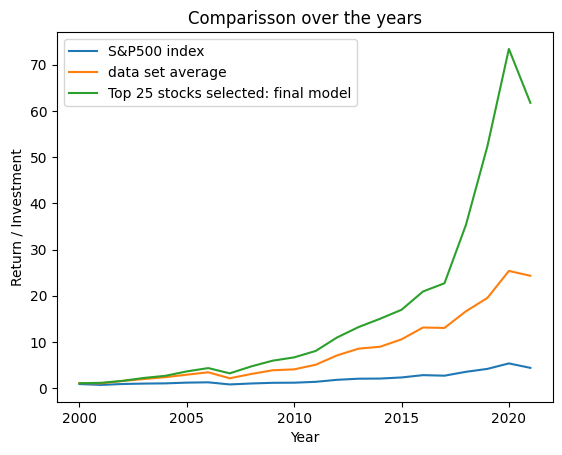

In [ ]:
# Create the plot
plt.plot(ac_return['year'], ac_return['index_return'], label='S&P500 index')
plt.plot(ac_return['year'], ac_return['avg_return'], label='data set average')
plt.plot(ac_return['year'], ac_return['model_return'], label='Top 25 stocks selected: final model')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Return / Investment')
plt.title('Comparisson over the years')

# Add legend
plt.legend()

# Show the plot
plt.show()

# 5. Which are the selected companies?

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = np.array(sp500[0]['Symbol'])
sp500_list = sp500_list.tolist()

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/TFM/03. Dataset exports/total_dataset_22_05.csv',sep=';')
df1 = df1[df1['Ticker'].isin(sp500_list)]

# Drop the index column
df1.drop('Unnamed: 0', axis=1, inplace=True)
print(df1.shape)

## 0. Deleting rows with np.nan in 'target'
df1 = df1.dropna(subset=['target'])
print(df1.shape)

## 1. Delete large instances
# Deleting rows where 'Feature' is greater than 10000
df2 = df1[df1['target'] <= 10000]

# Modifying values in 'Feature' column between 1000 and 10000
df2.loc[(df2['target'] >= 1000) & (df2['target'] <= 10000), 'target'] = 1000
print(df2.shape)

## 2. Delete instances where more than 40% are NAN
# Set the threshold
threshold_column = int(len(df2.columns)*0.60)

df3 = df2.dropna(thresh=threshold_column)
print(df3.shape)

## 3. Delete companies that has less than three years in the dataset
# Counting occurrences of each category
counts = df3['Ticker'].value_counts()

# Filtering rows based on category counts
df4 = df3[df3['Ticker'].map(counts) > 3]
print(df4.shape)

## 4. Delete instances where more than 40 % of the features are NANs.
# Set the threshold
threshold_row = int(len(df2)*0.60)

# Deleting columns with more than 40% NaN values
df5 = df4.dropna(axis=1, thresh=threshold_row)
print(df5.shape)

## 5. Replace infinity values with NaN
df5.replace([np.inf, -np.inf], np.nan, inplace=True)

(10211, 74)
(9826, 74)
(9826, 74)
(9795, 74)
(9784, 74)
(9784, 71)


<ipython-input-68-beb930e4c9d3>:1: DtypeWarning: Columns (10,13,16,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/drive/MyDrive/TFM/03. Dataset exports/total_dataset_22_05.csv',sep=';')
<ipython-input-68-beb930e4c9d3>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.replace([np.inf, -np.inf], np.nan, inplace=True)


Now see what companies are being selected

In [ ]:
selection = 25
selected_companies = pd.DataFrame(columns=['year','Ticker','target'])

for year in range(2000,2022):
    print(f'### year: {year} calculating ...')
    # File name
    file_name = ''.join(['/content/drive/MyDrive/TFM/06. Results/final/tuned_model/results_test_',str(year),'.csv'])

    df = pd.read_csv(file_name)

    sorted_df = df.loc[:,['y_test','y_prob_test']].sort_values('y_prob_test', ascending=False)

    # Calculate relevant variables
    mean_model = sorted_df['y_test'][:selection].mean()
    whole_mean = df['y_test'].mean()

    for i in range(selection):
        target = sorted_df['y_test'][:selection].iloc[i]
        try:
            ticker = df5[(df5['year']==year)&(df5['target']==target)].iloc[0,1]
        except:
            ticker = np.nan
        new_row = pd.DataFrame({
                                'year':[year],
                                'Ticker':[ticker],
                                'target':[target]
                                })
        # Append the new columns to the original dataframe
        selected_companies = pd.concat([selected_companies, new_row], axis=0)

### year: 2000 calculating ...
### year: 2001 calculating ...
### year: 2002 calculating ...
### year: 2003 calculating ...
### year: 2004 calculating ...
### year: 2005 calculating ...
### year: 2006 calculating ...
### year: 2007 calculating ...
### year: 2008 calculating ...
### year: 2009 calculating ...
### year: 2010 calculating ...
### year: 2011 calculating ...
### year: 2012 calculating ...
### year: 2013 calculating ...
### year: 2014 calculating ...
### year: 2015 calculating ...
### year: 2016 calculating ...
### year: 2017 calculating ...
### year: 2018 calculating ...
### year: 2019 calculating ...
### year: 2020 calculating ...
### year: 2021 calculating ...


In [ ]:
csv_to_save = '/content/drive/MyDrive/TFM/06. Results/final/selected_companies.csv'

# Save the DataFrame to a CSV file
selected_companies.to_csv(csv_to_save)